In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, random, pickle, json, itertools
import cv2
import imgaug.augmenters as iaa
from IPython.display import SVG


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

In [16]:
def show_final_history(history):

    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['acc'],label='Train Accuracy')
    ax[1].plot(history.history['val_acc'],label='Validation Accuracy')

    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    pass

def conv_block(X, k, filters, stage, block, s=2):
    conv_base_name = 'conv_' + str(stage) + block + '_branch'
    bn_base_name = 'bn_' + str(stage) + block + "_branch"

    F1 = filters

    X = Conv2D(filters=F1, kernel_size=(k, k), strides=(s, s),
               padding='same', name=conv_base_name + '2a')(X)
    X = BatchNormalization(name=bn_base_name + '2a')(X)
    X = Activation('relu')(X)

    return X
    pass

def augment_add(images, seq, labels):
    augmented_images, augmented_labels = [],[]
    for idx,img in tqdm(enumerate(images)):

        if labels[idx] == 1:
            image_aug_1 = seq.augment_image(image=img)
            image_aug_2 = seq.augment_image(image=img)
            augmented_images.append(image_aug_1)
            augmented_images.append(image_aug_2)
            augmented_labels.append(labels[idx])
            augmented_labels.append(labels[idx])
        pass

    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.float32)

    return (augmented_images, augmented_labels)
    pass


def basic_model(input_shape,classes):

    X_input = Input(input_shape)

    X = ZeroPadding2D((5,5))(X_input)

    X = Conv2D(16,(3,3),strides=(2,2),name='conv1',padding="same")(X)
    X = BatchNormalization(name='bn_conv1')(X)

    # stage 2
    X = conv_block(X,3,32,2,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 3
    X = conv_block(X,5,32,3,block='A',s=2)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 4
    X = conv_block(X,3,64,4,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#   Output Layer
    X = Flatten()(X)
    X = Dense(64)(X)
    X = Dropout(0.5)(X)

    X = Dense(128)(X)
    X = Activation("relu")(X)

    X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)

    model = Model(inputs=X_input,outputs=X,name='Feature_Extraction_and_FC')

    return model
    pass


def load_data():
    print("Loading ship data")
    ships_path = os.path.join('../../data/raw/','shipsnet.json')
    with open(ships_path) as file:
        dataset = json.load(file)

    labels = np.array(dataset["labels"]).astype("float32")

    img_length = 80
    images = np.array(dataset["data"]).astype("uint8")
    images = images.reshape(-1, 3, img_length, img_length).transpose([0, 2, 3, 1])
    images = [cv2.cvtColor(img,cv2.COLOR_BGR2RGB) for img in images]
    images = [cv2.resize(img, (48,48)) for img in images]
    images = np.array(images,dtype=np.float32)/255.0
    print("Data loaded")
    return images, labels


print("functions loaded")

functions loaded


# Load data
Loads the dataset and augments it such that the distribution between ship and noship classes is the same. Can choose between different types of augmentation

In [48]:
#"none","rotate", "lighting", "flip", "mix"
AUGMENTATION_TYPE = "none"

(images, labels) = load_data()
images.shape, labels.shape



if AUGMENTATION_TYPE == "rotate":
    seq = iaa.Sequential([
    iaa.Affine(
        rotate=(-25,25),
    )
], random_order=True)
if AUGMENTATION_TYPE == "flip":
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
], random_order=True)

if AUGMENTATION_TYPE == "lighting":
    seq = iaa.Sequential([
    iaa.LinearContrast((0.75,1.5)),
], random_order=True)

if AUGMENTATION_TYPE == "mix":
    seq = iaa.Sequential([
    iaa.LinearContrast((0.75,1.5)),
    iaa.Multiply((0.8,1.2), per_channel=True),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(-25,25),
    )
], random_order=True)
if AUGMENTATION_TYPE != "none":
    (aug_images, aug_labels) = augment_add(images, seq, labels)
    images = np.concatenate([images, aug_images])
    labels = np.concatenate([labels, aug_labels])
    for i in range(5000,5004):
        plt.imshow(images[i])
        plt.show()

labels = to_categorical(labels)


Loading ship data
Data loaded


# Test, train split  + shuffle

In [49]:
np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)


total_count = len(images)
total_count

train = int(0.8*total_count)
test = int(0.2*total_count)

train_images, train_labels = images[:train], labels[:train]
test_images, test_labels = images[-test:], labels[-test:]

train_images.shape, test_images.shape

((3200, 48, 48, 3), (800, 48, 48, 3))

# Image data generator
Imagge data generator for creating test/validation splits. Also allows

In [51]:
batch_size=30
if AUGMENTATION_TYPE == "none":
    idg = ImageDataGenerator(validation_split=0.2)

if AUGMENTATION_TYPE == "flip":
    idg = ImageDataGenerator(
        vertical_flip=True,
        horizontal_flip=True,
        validation_split=0.2)

if AUGMENTATION_TYPE == "rotate":
    idg = ImageDataGenerator(
        rotation_range=30,
        validation_split=0.2)

if AUGMENTATION_TYPE == "lighting":
    idg = ImageDataGenerator(
        brightness_range=[0.8, 1.2],
        validation_split=0.2)

if AUGMENTATION_TYPE == "mix":
    idg = ImageDataGenerator(
        brightness_range=[0.8, 1.2],
        rotation_range=30,
        vertical_flip=True,
        horizontal_flip=True,
        validation_split=0.2)

idg.fit(train_images)



train_generator = idg.flow(
    train_images,
    train_labels,
    batch_size=batch_size,
    seed = 42,
    shuffle=True,
    subset="training"
    )

val_generator = idg.flow(
    train_images,
    train_labels,
    batch_size=batch_size,
    seed = 42,
    shuffle=True,
    subset="validation",
    )


In [52]:
model = basic_model(input_shape=(48,48,3),classes=2)
model.summary()

Model: "Feature_Extraction_and_FC"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 58, 58, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 29, 29, 16)        448       
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 29, 29, 16)        64        
_________________________________________________________________
conv_2A_branch2a (Conv2D)    (None, 29, 29, 32)        4640      
_________________________________________________________________
bn_2A_branch2a (BatchNormali (None, 29, 29, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 29, 2

In [54]:
opt = Adam(lr=1e-4)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])

checkpoint = ModelCheckpoint("model_weights_aug.h5",monitor='val_acc',verbose=1,save_best_only=True,mode='max')
logs = TensorBoard("logs")




In [56]:
epochs = 150

history = model.fit(train_generator,
                              steps_per_epoch=train_generator.n//batch_size,
                              epochs=epochs,
                              validation_data=val_generator,
                              validation_steps=val_generator.n//batch_size,
                              callbacks=[checkpoint, logs],
                              verbose=1)

Epoch 1/6
85/85 [==============================] - ETA: 0s - loss: 0.4411 - acc: 0.7937 

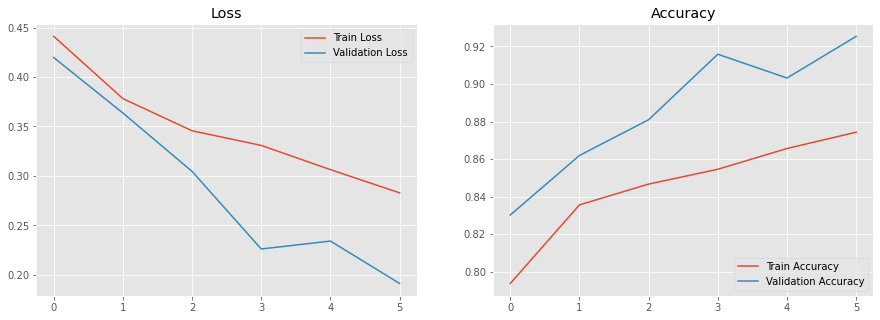

25/25 [==============================] - 0s 10ms/step - loss: 0.1757 - acc: 0.9425
Final test accuracy: 0.9424999952316284


In [57]:
show_final_history(history)

score, acc = model.evaluate(test_images, test_labels,)
print(f"Final test accuracy: {acc}")

**Saving the model**

ship-model-aug-flip-0.969-acc.h5


In [ ]:
model_name = "ship-model-aug-{}-{:.3f}-acc.h5".format(AUGMENTATION_TYPE, acc)
model.save(model_name)
print("saved")